In [1]:
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd
from scipy import stats

import pickle
from pathlib import Path

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import (precision_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import RandomOverSampler 

import catboost as catb


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_ROOT = Path('./choose-tutors/')
MODELS_PATH = Path('./models/')

TRAIN_PATH = DATA_ROOT / 'train.csv'
TEST_PATH = DATA_ROOT / 'test.csv'
SUBMIT_PATH = DATA_ROOT / 'submission_example.csv'

SCALER_FILE_PATH = MODELS_PATH / 'scaler.pkl'
MODEL_FILE_PATH = MODELS_PATH / 'model.pkl'

## 2. Загрузка данных в Data Frame
#### Описание файлов
- train.csv - тренировочные данные
- test.csv - тестовые данные
- submission_example.csv - образец файла для отправки в правильном формате
#### Описание признаков данных
- survival: выживший -1 или -0
- pclass: Класс билетов 1 = 1st, 2 = 2nd, 3 = 3rd
- sex: Пол
- Age: Возраст в годах
- sibsp: братьев и сестер/супругов на борту "Титаника"
- parch: родителей/детей на борту "Титаника"
- ticket: Номер билета
- fare: Пассажирский тариф
- cabin: Номер каюты
- embarked: Порт отправления C = Шербур, Q = Квинстаун, S = Саутгемптон


In [3]:
# Импортируем данные train.csv в pandas Dataframe
df_train = pd.read_csv(TRAIN_PATH, sep=',')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
 12  choose               10000 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 1015.8 KB


In [4]:
df_train = df_train.set_index('Id')
df_train.head()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
Id,,,,,,,,,,,,
0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0
3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1
4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0


## Рассмотрим поближе каждую характеристику 

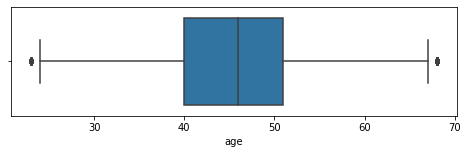


Количество пропущенных элементов 0
Количество уникальных элементов 46
median - 46.000
mean - 45.801
mode - 44.000
квантиль 5% - 33.000
квантиль 98% - 63.000


In [5]:
index = 'age'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
quantile = df_train.loc[df_train[index].notnull(), index]
print(f'Количество уникальных элементов {quantile.value_counts().size}')
print(f'median - {np.quantile(quantile, q=0.5):.3f}\nmean - {np.mean(quantile):.3f}\nmode - {stats.mode(quantile)[0][0]:.3f}')
print(f'квантиль 5% - {np.quantile(quantile, q=0.05):.3f}\nквантиль 98% - {np.quantile(quantile, q=0.98):.3f}')
#print(df_train[index].value_counts().sort_index(ascending=True))

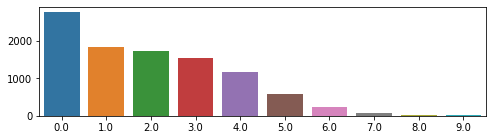

Количество пропущенных элементов 0
Количество уникальных элементов 10


In [6]:
index = 'years_of_experience'
counts = df_train[index].value_counts()
plt.figure(figsize=(8, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'Количество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'Количество уникальных элементов {df_train[index].value_counts().size}')
#print(df_train[index].value_counts())

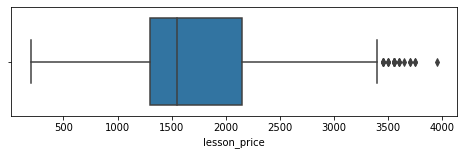


Количество пропущенных элементов 0
Количество уникальных элементов 71
median - 1550.000
mean - 1702.440
mode - 1450.000
квантиль 5% - 1100.000
квантиль 98% - 3000.000


In [7]:
index = 'lesson_price'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
quantile = df_train.loc[df_train[index].notnull(), index]
print(f'Количество уникальных элементов {quantile.value_counts().size}')
print(f'median - {np.quantile(quantile, q=0.5):.3f}\nmean - {np.mean(quantile):.3f}\nmode - {stats.mode(quantile)[0][0]:.3f}')
print(f'квантиль 5% - {np.quantile(quantile, q=0.05):.3f}\nквантиль 98% - {np.quantile(quantile, q=0.98):.3f}')
#print(df_train[index].value_counts().sort_index(ascending=True))

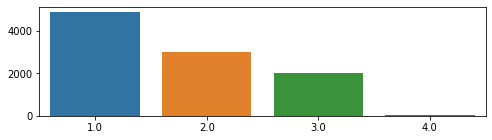

Количество пропущенных элементов 0
Количество уникальных элементов 4


In [8]:
index = 'qualification'
counts = df_train[index].value_counts()
plt.figure(figsize=(8, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'Количество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'Количество уникальных элементов {df_train[index].value_counts().size}')
#print(df_train[index].value_counts())

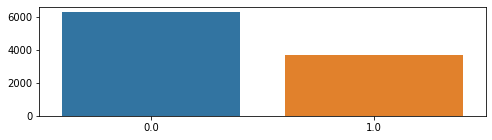

Количество пропущенных элементов 0
Количество уникальных элементов 2


In [9]:
index = 'physics'
counts = df_train[index].value_counts()
plt.figure(figsize=(8, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'Количество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'Количество уникальных элементов {df_train[index].value_counts().size}')
#print(df_train[index].value_counts())

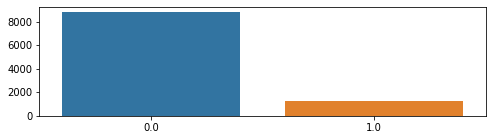

Количество пропущенных элементов 0
Количество уникальных элементов 2


In [10]:
index = 'chemistry'
counts = df_train[index].value_counts()
plt.figure(figsize=(8, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'Количество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'Количество уникальных элементов {df_train[index].value_counts().size}')
#print(df_train[index].value_counts())

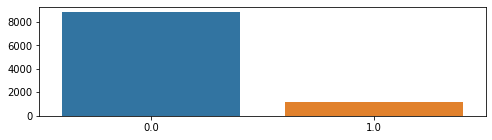

Количество пропущенных элементов 0
Количество уникальных элементов 2


In [11]:
index = 'biology'
counts = df_train[index].value_counts()
plt.figure(figsize=(8, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'Количество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'Количество уникальных элементов {df_train[index].value_counts().size}')
#print(df_train[index].value_counts())

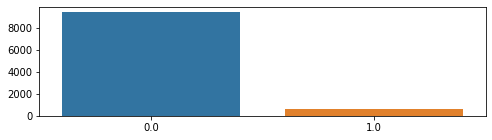

Количество пропущенных элементов 0
Количество уникальных элементов 2


In [12]:
index = 'english'
counts = df_train[index].value_counts()
plt.figure(figsize=(8, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'Количество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'Количество уникальных элементов {df_train[index].value_counts().size}')
#print(df_train[index].value_counts())

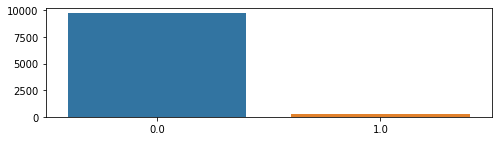

Количество пропущенных элементов 0
Количество уникальных элементов 2


In [13]:
index = 'geography'
counts = df_train[index].value_counts()
plt.figure(figsize=(8, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'Количество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'Количество уникальных элементов {df_train[index].value_counts().size}')
#print(df_train[index].value_counts())

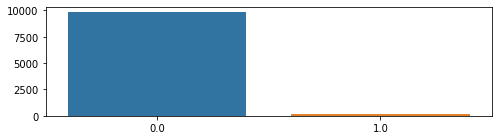

Количество пропущенных элементов 0
Количество уникальных элементов 2


In [14]:
index = 'history'
counts = df_train[index].value_counts()
plt.figure(figsize=(8, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'Количество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'Количество уникальных элементов {df_train[index].value_counts().size}')
#print(df_train[index].value_counts())

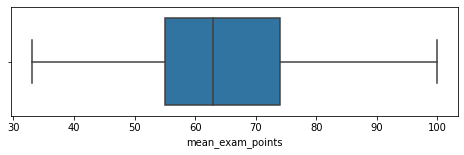


Количество пропущенных элементов 0
Количество уникальных элементов 68
median - 63.000
mean - 64.435
mode - 62.000
квантиль 5% - 42.000
квантиль 98% - 91.000


In [15]:
index = 'mean_exam_points'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
quantile = df_train.loc[df_train[index].notnull(), index]
print(f'Количество уникальных элементов {quantile.value_counts().size}')
print(f'median - {np.quantile(quantile, q=0.5):.3f}\nmean - {np.mean(quantile):.3f}\nmode - {stats.mode(quantile)[0][0]:.3f}')
print(f'квантиль 5% - {np.quantile(quantile, q=0.05):.3f}\nквантиль 98% - {np.quantile(quantile, q=0.98):.3f}')
#print(df_train[index].value_counts().sort_index(ascending=True))	

### Целевая переменная

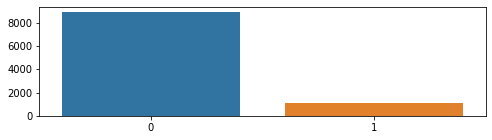

Количество пропущенных элементов 0
Количество уникальных элементов 2
0    8891
1    1109
Name: choose, dtype: int64


In [16]:
index = 'choose'
counts = df_train[index].value_counts()
plt.figure(figsize=(8, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'Количество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'Количество уникальных элементов {df_train[index].value_counts().size}')
print(df_train[index].value_counts())

### *Вывод: имеем дисбаланс классов, в последствии будем проводить балансировку методом Oversampling*

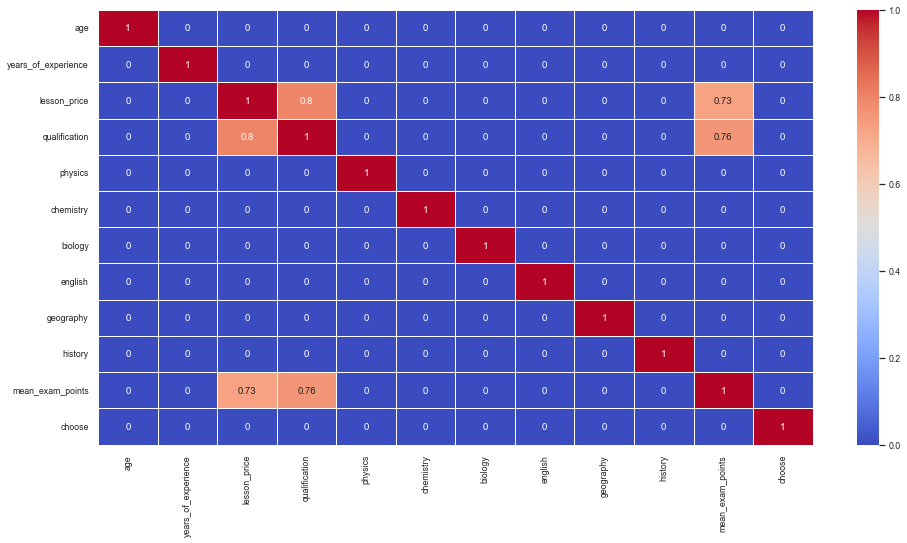

In [17]:
train_df_corr = df_train.corr()
plt.figure(figsize = (16,8))
sns.set(font_scale=0.8)
train_df_corr_round = np.round(train_df_corr, 2)
train_df_corr_round[np.abs(train_df_corr) < 0.3] = 0
sns.heatmap(train_df_corr_round, annot=True, linewidths=.5, cmap='coolwarm')
plt.show()

### Вспомогательные функции

In [18]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [19]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    """"Метрики"""
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print('TRAIN\n\n' + classification_report(y_train, y_train_pred))
    plot_confusion_matrix(model, X_train, y_train, cmap=plt.cm.Blues)
    plot_precision_recall_curve(model, X_train, y_train)
    plot_roc_curve(model, X_train, y_train)
    print('\n\nTEST\n\n' + classification_report(y_test, y_test_pred))
    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
    plot_precision_recall_curve(model, X_test, y_test)
    plot_roc_curve(model, X_test, y_test)

In [20]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Подбор оптимального размера выборки, кривая обучения"""
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [21]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    """Выбор порога вероятности для определения класса"""
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [22]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    """Важность признаков"""
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

## Обработка данных

In [23]:
df_train = pd.read_csv(TRAIN_PATH, sep=',')
test_df = pd.read_csv(TEST_PATH, sep=',')
sumbit_df = pd.read_csv(SUBMIT_PATH, sep=',')

y = df_train['choose']
X = df_train.drop(columns=['choose'])
X = X.set_index('Id')
test_df = test_df.set_index('Id')


In [24]:
scaler = RobustScaler()#StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
test = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

In [25]:
X = reduce_mem_usage(X)
test = reduce_mem_usage(test)

Memory usage of dataframe is 0.84 MB
Memory usage after optimization is: 0.42 MB
Decreased by 50.0%
Memory usage of dataframe is 0.84 MB
Memory usage after optimization is: 0.42 MB
Decreased by 50.0%


### *Разбиение на train и test*

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42, stratify=y)
X_train.shape, X_valid.shape, test.shape, len(y_train), len(y_valid), len(sumbit_df['choose'])

((7500, 11), (2500, 11), (10000, 11), 7500, 2500, 10000)

### Балансировка целевой переменной

In [27]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

8.014423076923077

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.77      0.86      6668
           1       0.31      0.85      0.45       832

    accuracy                           0.77      7500
   macro avg       0.64      0.81      0.66      7500
weighted avg       0.90      0.77      0.81      7500



TEST

              precision    recall  f1-score   support

           0       0.96      0.75      0.85      2223
           1       0.28      0.77      0.41       277

    accuracy                           0.76      2500
   macro avg       0.62      0.76      0.63      2500
weighted avg       0.89      0.76      0.80      2500



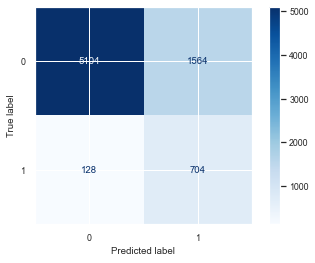

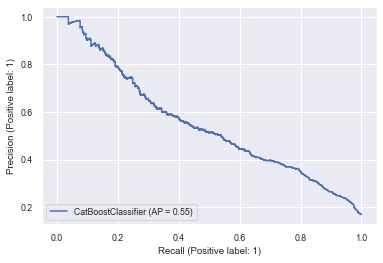

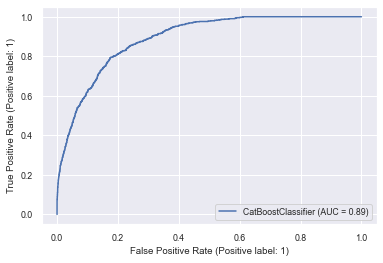

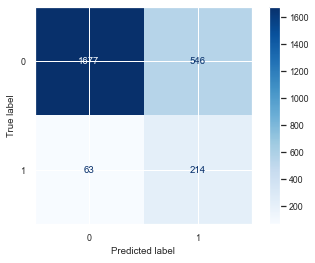

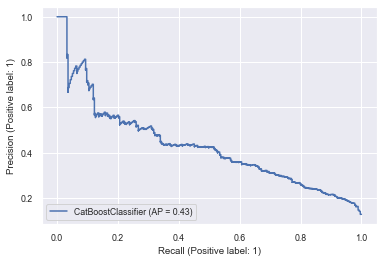

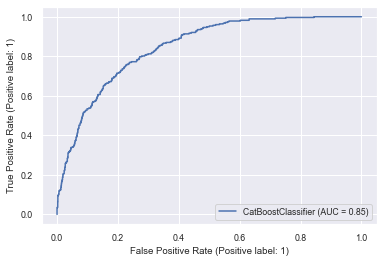

In [28]:
frozen_params = {'class_weights':[1, disbalance], 
                 'silent':True,
                 'random_state':42,
                 #'eval_metric':'F1',
                 'custom_loss':['AUC', 'Accuracy', 'F1'],
                 'early_stopping_rounds':100
}

model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, min_data_in_leaf = 1)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_valid, y_valid))

evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

In [29]:
frozen_params = {'class_weights':[1, disbalance], 
                 'silent':True,
                 'random_state':42,
                 'eval_metric':'F1',
                 #'custom_loss':['AUC', 'Accuracy', 'F1'],
                 'early_stopping_rounds':100
}

In [30]:
params = {'reg_lambda': np.linspace(0.1, 1, 20)}

cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

model = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                min_data_in_leaf = 1
                                )

grid_search = model.randomized_search(params, 
                        X_train, y_train, n_iter=20, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7692729932
bestIteration = 87

0:	loss: 0.7692730	best: 0.7692730 (0)	total: 489ms	remaining: 9.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7733289514
bestIteration = 86

1:	loss: 0.7733290	best: 0.7733290 (1)	total: 993ms	remaining: 8.94s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7774165945
bestIteration = 133

2:	loss: 0.7774166	best: 0.7774166 (2)	total: 1.68s	remaining: 9.53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7853691127
bestIteration = 137

3:	loss: 0.7853691	best: 0.7853691 (3)	total: 2.48s	remaining: 9.91s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7803675861
bestIteration = 118

4:	loss: 0.7803676	best: 0.7853691 (3)	total: 3.12s	remaining: 9.35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7779755969
bestIteration = 188

5:	loss: 0.7779756	best: 0.7853691 (3)	total: 3.94s	

In [31]:
reg_lambda_ = grid_search['params']['l2_leaf_reg']
reg_lambda_

0.6210526315789474

### Подбор оптимального размера выборки, кривая обучения

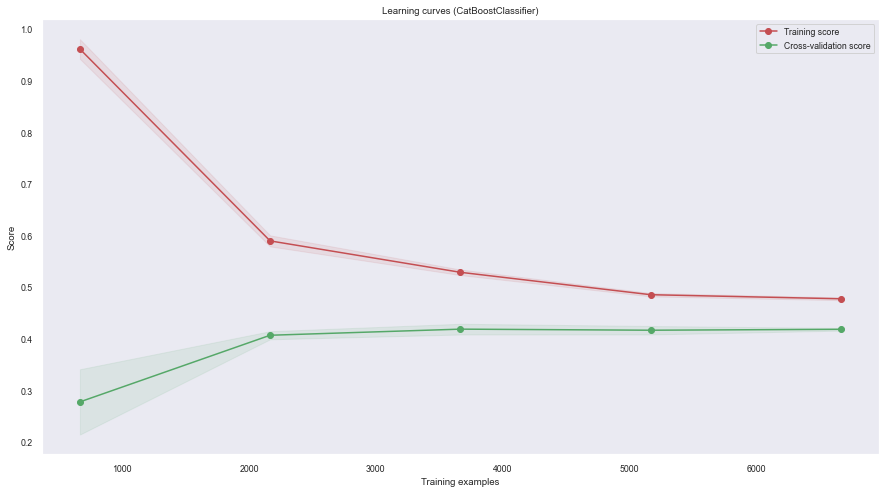

In [32]:
show_learning_curve_plot(model, X, y)

### Выбор порога вероятности для определения класса

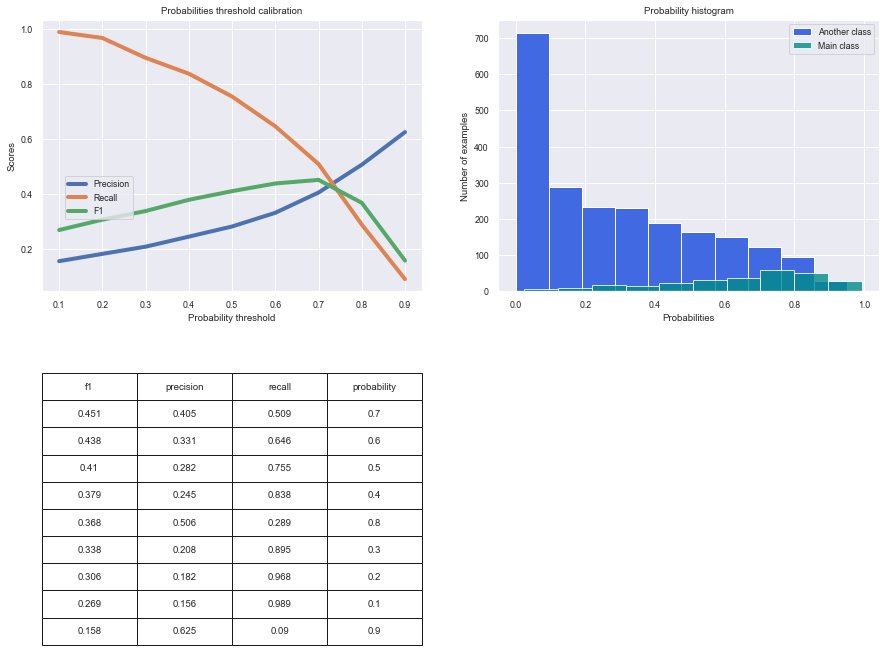

In [33]:
y_test_pred_probs = model.predict_proba(X_valid)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_valid)

### Важность признаков<a class="anchor" id="feature_importances"></a>

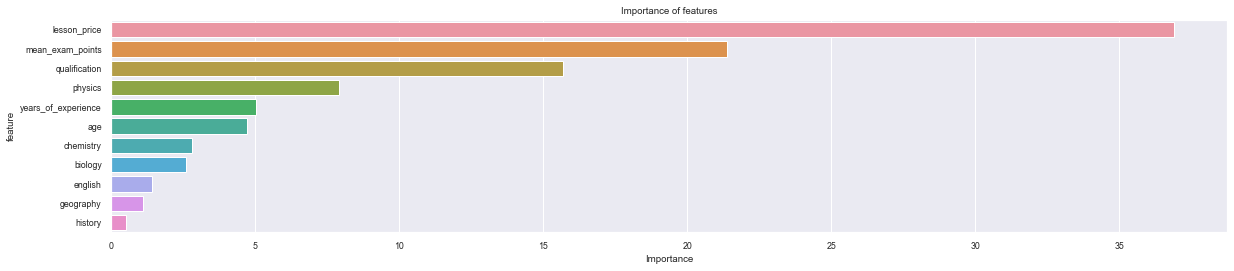

In [34]:
important_features_top = show_feature_importances(X_train.columns, model.feature_importances_)

### Построение лучшей модели

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.77      0.86      6668
           1       0.31      0.85      0.46       832

    accuracy                           0.77      7500
   macro avg       0.64      0.81      0.66      7500
weighted avg       0.90      0.77      0.81      7500



TEST

              precision    recall  f1-score   support

           0       0.96      0.75      0.85      2223
           1       0.28      0.77      0.41       277

    accuracy                           0.75      2500
   macro avg       0.62      0.76      0.63      2500
weighted avg       0.89      0.75      0.80      2500



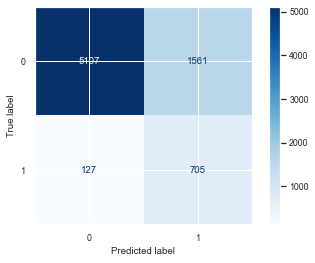

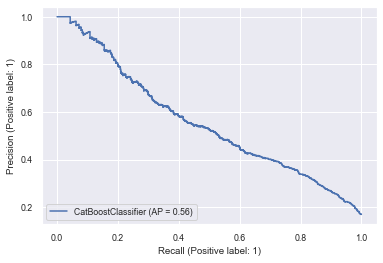

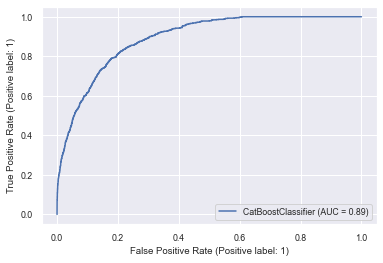

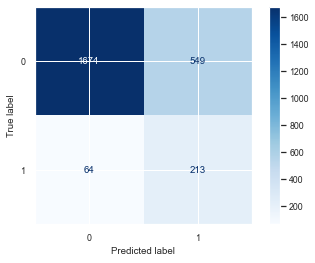

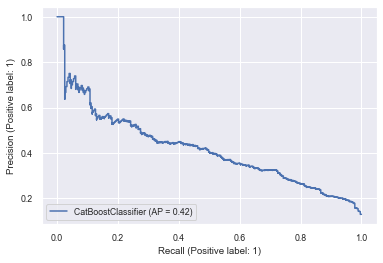

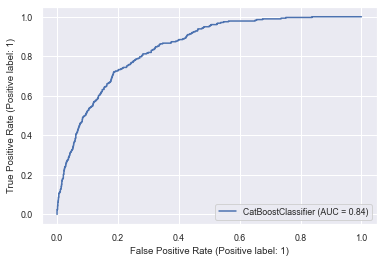

In [35]:
frozen_params = {'class_weights':[1, disbalance], 
                 'silent':True,
                 'random_state':42,
                 #'eval_metric':'F1',
                 'custom_loss':['AUC', 'Accuracy', 'F1'],
                 'early_stopping_rounds':100
                }

final_model = catb.CatBoostClassifier(**frozen_params,
                                      iterations=300,
                                      #max_depth=7,
                                      min_data_in_leaf = 1,
                                      reg_lambda=reg_lambda_
                                      )

final_model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

evaluate_preds(final_model, X_train, X_valid, y_train, y_valid)

In [36]:
def accuracy_metric(actual, predicted):
    """Подсчет метрики Accuracy"""
    actual = np.array(actual)
    predicted = np.array(predicted)
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [37]:
y_test_pred_probs = final_model.predict_proba(X_valid)
pred_test = np.where(y_test_pred_probs[:, 1] >= 0.7, 1, 0)
print(f'Accuracy: {accuracy_metric(y_valid, pred_test):.3f}')
print(f'ROC AUC: {roc_auc_score(y_valid, pred_test):.3f}')
print('Classification report')
print(classification_report(y_valid, pred_test))

Accuracy: 86.800
ROC AUC: 0.698
Classification report
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      2223
           1       0.42      0.48      0.45       277

    accuracy                           0.87      2500
   macro avg       0.68      0.70      0.69      2500
weighted avg       0.88      0.87      0.87      2500



### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [38]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

### Финальная модель

In [39]:
y_test_pred = final_model.predict_proba(test)

### Сохранение результата

In [40]:
sumbit_df['choose'] = y_test_pred[:, 1]
sumbit_df.to_csv('SergeyLazarevich_predictions.csv', index=False)